# statische Optimierung mit Beschränkungen

$
min  \hspace{1cm}      f(x)   \\
u.B.v.  \qquad    g_{i}(x) = 0  \qquad  i = 1,....,p  \\
        \hspace{1.6cm}   h_{i}(x) \leq 0  \qquad  i = 1,....,q \\
$

angeschrieben als Lamdafunktion

$
L(x, \lambda, \mu) = f(x) + g_{i}(x)^{T}\lambda + h_{i}(x)^{T}\mu 
$

## statische Optimierung mit Gleichheitsbeschränkung
$
L(x,\lambda) = f(x) + g_{i}(x)^{T}\lambda 
$

In [1]:
import numpy as np
Q = np.eye(2)
f = lambda x: ([x[0]-1,x[1]])@Q@([x[0]-1,x[1]])*1/2
df = lambda x: Q@[x[0]-1,x[1]]
ddf = lambda x:  Q.copy()

A = np.array([1,-1])
b = -1
c = lambda x: A@x-b
dc = lambda x: A.copy()

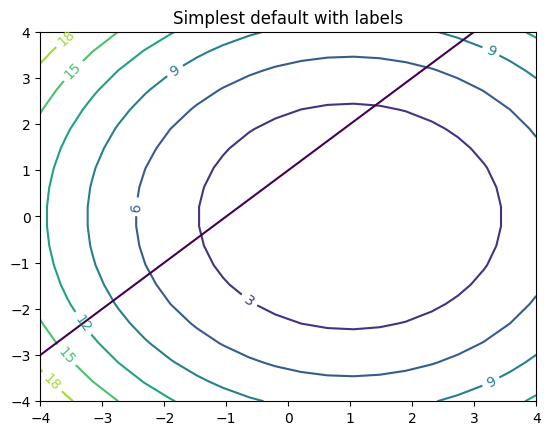

In [2]:
# Plot
import matplotlib.cm as cm
import matplotlib.pyplot as plt
def plot(f,N=20):    
    x = np.linspace(-4,4,N)
    y = np.linspace(-4,4,N)    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((N,N))
    Z2 = Z.copy()
    for i in range(N):
        for j in range(N):
            Z[i,j] = f([X[i,j],Y[i,j]])
            Z2[i,j] = c([X[i,j],Y[i,j]])
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)    
    ax.contour(X, Y, Z2,[0])
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Simplest default with labels')
    return Z2


Z = plot(f)
#plt.scatter(1,1, c='r', marker='o',s=50)

plt.show()

In [3]:
# Lambda Funktion

def La(f,x,l,rho):
    p = max(0,c(x))
    return f(x) + l*p + (rho/2)@p@p 

In [4]:
def newton_solve(x0,l,rho, tol = 1e-8):
    x = x0
    p = max(0,c(x))
    C = np.zeros((len(x0)))
    if c(x) >= 0:
        C = dc(x)

    g = df(x) + (l+rho*p)*C
    k = 0
    while np.linalg.norm(g) >= tol and k < 20:
        H       = ddf(x) + rho*C@C
        x += -np.inv(H)@g 

        p = max(0,c(x))
        C = np.zeros((len(x0)))
        if c(x) >= 0:
            C = dc(x)
            g = df(x) + (l+rho*p)@C
        k += 1
    return x



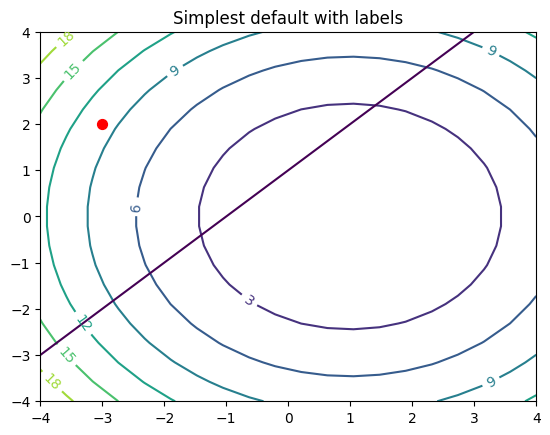

In [5]:
x0 = np.array([-3,2])
l0 = np.array([0,0])
rho = 1
plot(f)
plt.scatter(x0[0],x0[1], c='r', marker='o',s=50)

In [ ]:
x_new = newton_solve(x0,l0,rho)
la_new = max(0, l0[-1]+rho*c(x_new[-1]))

plot(f)
plt.scatter(x_new[0],x_new[1], c='r', marker='o',s=50)

## 4.4 Sequentielle Quadratische Optimierung (SQP)
**Skriptum TU-Wien Optimierung, S. 100 ff**

annäherung des allgemeinen Optimierungsproblems mittels quadratisches Programm in jedem Iterationsschritt     
       
$
min  \hspace{1cm}      f(x_{k}+(\nabla f)^{T}(x_{k}))\tilde{p}  + \frac{1}{2}\tilde{p} ^{T}L(x_{k}, \lambda _{k}, \mu _{k})\tilde{p}  \\
u.B.v.  \qquad    \nabla g(x)^{T}x_{k}\tilde{p} + g(x_{k}) = 0  \qquad   \\
        \hspace{1.6cm}   \nabla h^{T} x_{k} \tilde{p}   + h(x_{k}) \leq 0  \\
$

mit der Approximation 
$
 L(x, \lambda, \mu) = (\frac{\partial^{2}}{\partial x^{2}}L) (x, \lambda, \mu)
$
### KKT Bedingungen
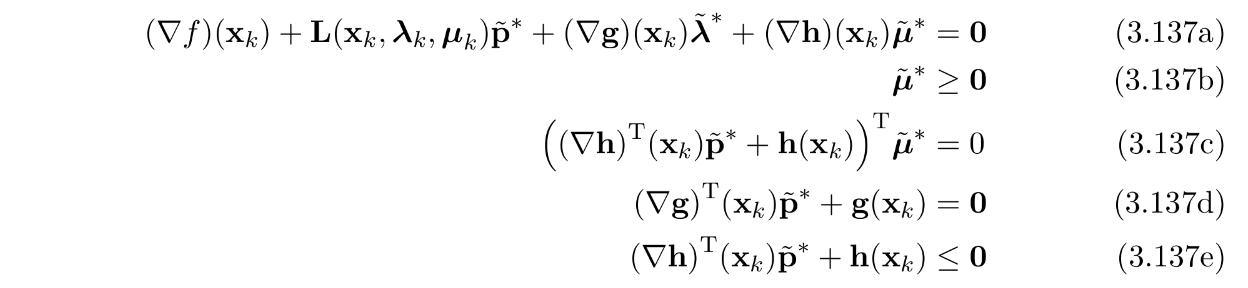

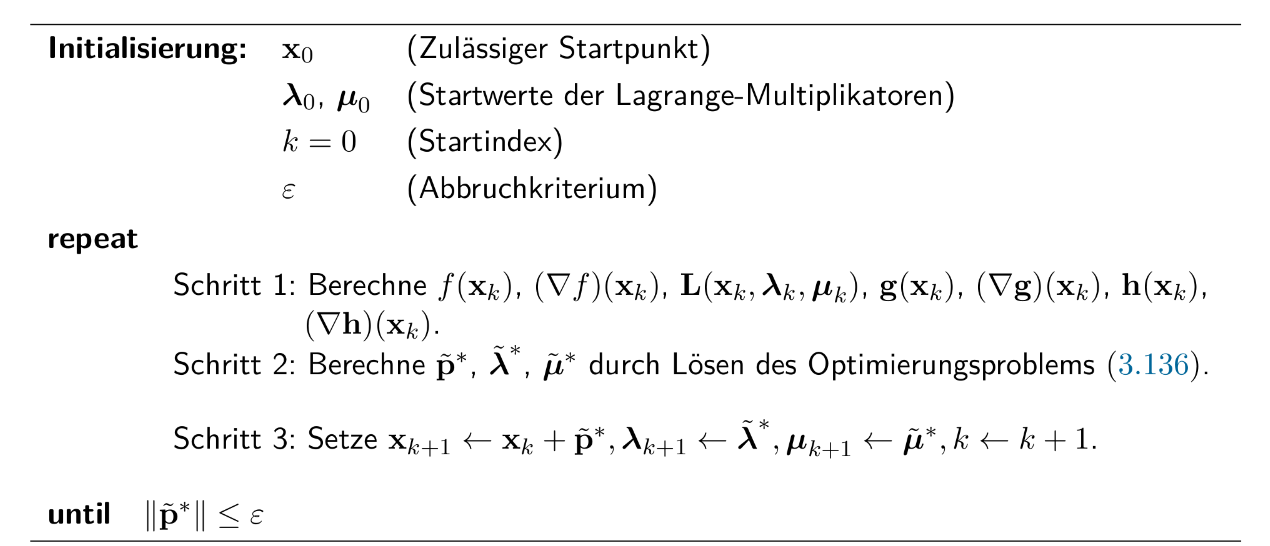

In [1]:
# Beispiel Rosenbrockfunktion

f = lambda x: 100*(x[1]-x[0]**2)**2 +(x[0]-1)**1
g = lambda x: - (x[0]**2+x[1]**2) +0.5**2


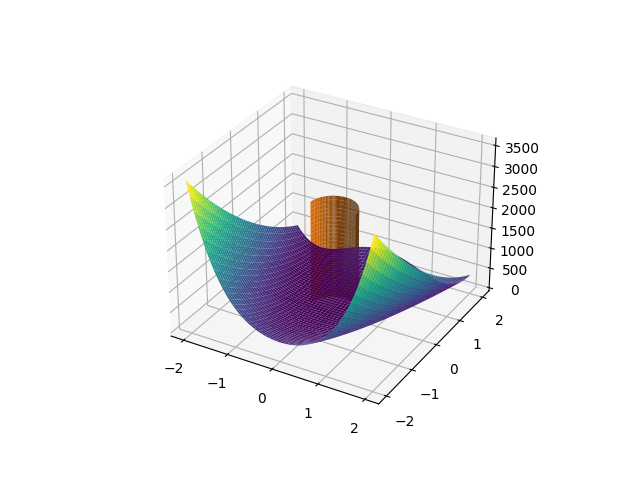

In [5]:
# Plotten
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
N = 500
x1 = np.linspace(2,-2,N)
x2 = np.linspace(2,-2,N)
xc = np.linspace(0.5,-0.5,N)
zc = np.linspace(0,2500,N)
X,Y = np.meshgrid(x1,x2)
Xc,Zc = np.meshgrid(xc,zc)
Z = f([X,Y])
Yc = (0.5**2-Xc**2)**0.5 

# creating figure
#fig = plt.figure()
#ax = Axes3D(fig)

ax = plt.figure().add_subplot(projection='3d')


ax.plot_surface(X, Y, Z, cmap='viridis')
ax.plot_surface(Xc, Yc, Zc, rstride=20, cstride=10)
plt.show()


In [ ]:
# SQP Verfahren

from optimierung import *




In [ ]:
def SQP_quasiNewton_3D(x,x_alt,df, B_alt):
    # Approzimierung der Hesse Matrix
    epsilon = 1e-30
    d = np.array([x -x_alt])
    y = np.array([df(x)-df(x_alt)])

    rho = 1/(y@d.T +epsilon)
    # aktualisieren der Inversen
    B = (np.eye(len(x))-rho*d.T@y)*B_alt*(np.eye(len(x))-rho*y.T@d) + rho*d.T@d
            
    # Regularisierung
    beta = np.eye(len(x))*0.01
    while not np.all(np.linalg.eigvals(B)):
            B += beta       
    s = -B@df(x)

 
    # Schrittweitenstrategie
    # Wolf Powel, vereinfacht
    
    alpha = 1   
    b= 0.5
    while f(x+alpha*s)>f(x):
        alpha = alpha*b        

    return x + alpha*s , B

In [ ]:

def Linesearch(x0,f,df,ddf,N,e_x = 1e-5, e_f = 1e-15):
    """ Animation
        Params
         --------
        x0:            Startwerte
        e_x:           Abbruchkriterium für die Schrittweite
        e_f:           Abbruchkriterium für den Funktionswert
        f:             Funktion
        df:            Ableitung der Funktion
        Returns
        --------     

        x:              Minimum     
        k:              steps
        X:        Step size                                       
    """

    x = x0  
    x_alt = x0    
    k = 0
    B0 = 1 #np.eye(np.size(x))  
    x = x0 - 1e-3*Forward_diff(f,x0)
    X = np.zeros(N)
    while k < N:       

        x,B0 = quasiNewton_3D(x,x_alt,df,B0)       
        
        #ax.scatter(x[0],x[1],f(x), c='r', marker='o', s = 50)        
                    
        X[k] = np.linalg.norm(x_alt-x)
        k += 1 
        # Abbruchkriterium
        if np.linalg.norm(x_alt-x) < e_x or np.linalg.norm(df(x_alt)-df(x)) < e_f:            
            return x,k,X

        x_alt = x 
        
        
            

    return x,k,np.linalg.norm(x_alt-x),X